In [1]:
import os
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import load_model
from pathlib import Path
import numpy as np

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
#dataset pre-processing
BATCH_SIZE = 32
img_size = (224,224)
#training data generator
traingen = ImageDataGenerator(       rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input)

#test dataset generator
testgen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [3]:
#dataset path for training and testing data
path_to_training_data = 'E:/ambience_mode/dataset/train'
path_to_testing_data = 'E:/ambience_mode/dataset/test'

#class labels
labels = os.listdir(path_to_training_data)
#training data
training_data = traingen.flow_from_directory(  path_to_training_data,
                                               target_size=img_size,
                                               class_mode='categorical',
                                               classes=labels,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)
#validation data
validation_data = traingen.flow_from_directory(path_to_training_data,
                                               target_size=img_size,
                                               class_mode='categorical',
                                               classes=labels,
                                               subset='validation',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

#testing data
testing_data = testgen.flow_from_directory(    path_to_testing_data,
                                               target_size=img_size,
                                               class_mode=None,
                                               classes=labels,
                                               batch_size=1, 
                                               shuffle=False,
                                               seed=42)

Found 1275 images belonging to 5 classes.
Found 223 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


In [4]:
model_path = 'E:/ambience_mode/new metrics'


In [5]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
top_weights_path = os.path.join(os.path.abspath(model_path), 'best_model_weights.h5')
callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_accuracy', patience=5, verbose=0)
    ]

In [6]:
model = load_model(os.path.join(os.path.abspath(model_path), 'best_model_weights.h5'))

In [7]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
model.fit(training_data, epochs=20, validation_data=validation_data,callbacks=callbacks_list)

Epoch 1/20
40/40 [==============================] - 190s 5s/step - loss: 0.7156 - accuracy: 0.7341 - val_loss: 0.6798 - val_accuracy: 0.7444

Epoch 00001: val_accuracy improved from -inf to 0.74439, saving model to E:\ambience_mode\new metrics\best_model_weights.h5


c:\users\raihan\anaconda3\envs\obj_detection\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
40/40 [==============================] - 161s 4s/step - loss: 0.7424 - accuracy: 0.7310 - val_loss: 0.7808 - val_accuracy: 0.7130

Epoch 00002: val_accuracy did not improve from 0.74439
Epoch 3/20
40/40 [==============================] - 159s 4s/step - loss: 0.7167 - accuracy: 0.7373 - val_loss: 0.6523 - val_accuracy: 0.7668

Epoch 00003: val_accuracy improved from 0.74439 to 0.76682, saving model to E:\ambience_mode\new metrics\best_model_weights.h5
Epoch 4/20
40/40 [==============================] - 161s 4s/step - loss: 0.6833 - accuracy: 0.7553 - val_loss: 0.6710 - val_accuracy: 0.7309

Epoch 00004: val_accuracy did not improve from 0.76682
Epoch 5/20
40/40 [==============================] - 159s 4s/step - loss: 0.6485 - accuracy: 0.7592 - val_loss: 0.6484 - val_accuracy: 0.7578

Epoch 00005: val_accuracy did not improve from 0.76682
Epoch 6/20
40/40 [==============================] - 158s 4s/step - loss: 0.6540 - accuracy: 0.7624 - val_loss: 0.6746 - val_accuracy: 0.7489

In [51]:
import cv2


In [263]:
#important for inference
img = cv2.imread('E:/ambience_mode/dataset/test/rainy/rain_6.jpg')
img = cv2.resize(img,(224,224))
img = np.array(img)
img = (img/255)*2-1 #does the exact same thing as preprocess_input function of MobilenetV2 which is essential for preprocessing
img = np.around(img,decimals=7)
img = np.expand_dims(img,axis=0)

In [264]:
model=load_model(os.path.join(os.path.abspath(model_path), 'best_model_weights.h5'))

In [265]:
pred = model.predict(img)

In [266]:
print(np.around(pred,decimals=3))

[[0.014 0.141 0.839 0.    0.005]]


In [270]:
pred_classes = np.argmax(pred, axis=1)
print(labels[pred_classes[0]])

rainy


In [82]:
true_label = []
predicted_label = []

for i in testing_data.classes:
    true_label.append(labels[i])

for i in pred_classes:
    predicted_label.append(labels[i])

print(true_label)
print(predicted_label)

['cloudy', 'cloudy', 'cloudy', 'cloudy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'rainy', 'rainy', 'rainy', 'rainy', 'rainy', 'rainy', 'shine', 'shine', 'shine', 'sunrise', 'sunrise', 'sunrise', 'sunrise', 'sunrise', 'sunrise', 'sunrise']
['cloudy', 'cloudy', 'shine', 'cloudy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'foggy', 'rainy', 'rainy', 'foggy', 'foggy', 'rainy', 'shine', 'shine', 'shine', 'sunrise', 'sunrise', 'sunrise', 'sunrise', 'sunrise', 'sunrise', 'sunrise']


In [227]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Text(69.0, 0.5, 'Truth')

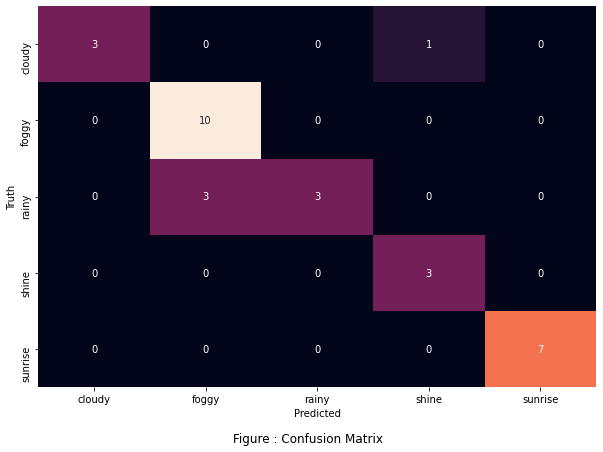

In [83]:
cm_labels = np.unique(true_label)
cm_array = confusion_matrix(true_label, predicted_label)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)


#cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)

%matplotlib inline

plt.figure(figsize=(10,7)).supxlabel('Figure : Confusion Matrix')

sns.heatmap(cm_array_df, annot=True,cbar = False) 
#sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

TypeError: Invalid shape (1, 224, 224, 3) for image data

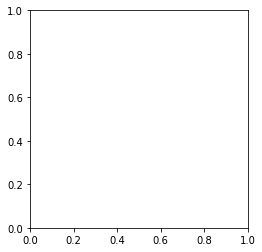